<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [46]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut,KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [45]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness index': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians (%)': 7,
        'muslims (%)': 8,
        'no religion (%)': 9,
        'buddhists (%)': 10,
        'hindus (%)': 11,
        'jews (%)': 12,
        'other religion (%)': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'post-HS education men (%)': 20,
        'Post-HS education women (%)': 21,
        'human development index': 22,
        'gender inequality index': 23,
        'first marriage age women': 24,
        'first marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortion rate': 29,
        'social media users': 30
    }
    countries = sorted(list(set([key[0] for key in data.keys()])))
    df = pd.DataFrame(index=countries, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for country in countries:
        key = (country, year)
        if key in data:
            features = data[key][1]
            target.append(data[key][0])
            for feature_name, feature_index in feature_map.items():
                if feature_index < len(features):
                  df.loc[country, feature_name] = features[feature_index]
                  if str(features[feature_index]) =='nan':
                    df.loc[country, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 3 years
    for i in range(1, 4):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 3 years, linearly extrapulate from last decade
    recent_years_data = []
    for i in range(10,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c
            return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return values[-1] # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [44]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(country)

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process 2023 data:
add some missing data, split to train and test and normalize

In [50]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortion rate': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25, 'Congo, Rep.': 39
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        },
        'gender inequality index':{
            'Central African Republic':0.682
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if country in df_features.index:
                df_features.loc[country, feature] = value

    # Convert all columns to numeric, coercing errors
    df_features = df_features.apply(pd.to_numeric, errors='coerce')

    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [53]:
def plot_features(X_train):

  # Get the list of columns
  columns = X_train.columns

  # Calculate the number of rows needed
  n_cols = 5
  n_rows = math.ceil(len(columns) / n_cols)

  # Create subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

  # Plot histograms for all features
  for i, column in enumerate(columns):
      axes[i].hist(X_train[column], bins=10)
      axes[i].set_title(f'Histogram of {column}')
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Frequency')
      axes[i].grid(True)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [52]:
class Scaling2023(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None, region_features=None):
        self.log_features=log_features or ['no religion (%)','other religion (%)','buddhists (%)','hindus (%)','jews (%)','GNI PPP']
        self.health_features=health_features or ['physicians per capita','health expenditure']
        # Define region features
        self.region_features = region_features or [
            'in Asia-Pacific', 'in Europe', 'in Latin America-Caribbean',
            'in Middle East-North Africa', 'in North America', 'in Sub-Saharan Africa'
        ]
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','happiness index','GNI PPP','female labor participation','christians (%)','muslims (%)','no religion (%)',
            'buddhists (%)','hindus (%)','jews (%)','other religion (%)','post-HS education men (%)','post-HS education men (%)',
            'human development index','gender inequality index','first marriage age women','first marriage age men','maternity leave index',
            'work hours men','work hours women','abortion rate','social media users','healthcare index score'
        ]
        self.health_scaler=StandardScaler()
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()

        # Convert region features to numeric (assuming they are binary indicators)
        for f in self.region_features:
            X_copy[f] = pd.to_numeric(X_copy[f], errors='coerce').fillna(0) # Handle potential non-numeric values

        missing=[c for c in (self.health_features+self.log_features) if c not in X_copy.columns]
        if missing: raise KeyError(f"Missing columns: {missing}")

        self.health_scaler.fit(X_copy[self.health_features])
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()

        # Convert region features to numeric (assuming they are binary indicators)
        for f in self.region_features:
            X_copy[f] = pd.to_numeric(X_copy[f], errors='coerce').fillna(0) # Handle potential non-numeric values

        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

In [27]:
def create_health_index_score(X_train,X_test):
    scaler_healthcare = StandardScaler()
    health_features = ['physicians per capita','health expenditure']
    X_train[health_features] = scaler_healthcare.fit_transform(X_train[health_features])
    X_test[health_features] = scaler_healthcare.transform(X_test[health_features])
    X_train['healthcare index score'] = X_train['physicians per capita'] + X_train['health expenditure']
    X_test['healthcare index score'] = X_test['physicians per capita'] + X_test['health expenditure']
    X_train = X_train.drop(['physicians per capita', 'health expenditure'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure'], axis=1)
    return X_train,X_test

In [28]:
def feature_correlations(df, method):
    """Calculates and visualizes correlation matrix, and prints top 5 correlated pairs."""

    correlation_matrix = df.corr(method=method)

    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap of Features in X_train')
    plt.show()

    print(f"\nTop 5 most highly correlated pairs of features (absolute {method.capitalize()} correlation):")
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    stacked_corr = upper_tri.stack().sort_values(ascending=False, key=abs)
    top_5_correlated_pairs = stacked_corr.head(5)

    if top_5_correlated_pairs.empty:
        print("No correlated pairs found.")
    else:
        for (feature1, feature2), correlation in top_5_correlated_pairs.items():
            print(f"  {feature1} and {feature2}: {correlation:.4f}")


In [29]:
def analyze_target_correlation(X, y, method_name):
    combined_data = pd.concat([X, y], axis=1)
    correlation_series = combined_data.corr(method=method_name)['target'].drop('target').sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')
    plt.title(f'{method_name} Correlation of Features with Target Variable')
    plt.xlabel(f'{method_name} Correlation Coefficient')
    plt.ylabel('Features')
    plt.show()

    print(f"\n{method_name} Correlation with Target:")
    print(correlation_series)


In [30]:
def analyze_mutual_information(X, y):
    """Calculates and displays Mutual Information scores of features with the target."""
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("Mutual Information Scores of Features with Target Variable:")
    print(mi_scores)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')
    plt.title('Mutual Information Scores of Features with Target Variable')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [33]:
def gridsearch_loocv_lasso(X,y):
    pipe=Pipeline([('scaling2023',Scaling2023()),('lasso',Lasso())])
    param_grid={'lasso__alpha':[val*(10**i) for i in range(-12,4) for val in [1,2,5]]}
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_elastic_net_loocv(X,y):
    pipe=Pipeline([('scaling2023',Scaling2023()),('elastic',ElasticNet())])
    param_grid={
        'elastic__alpha':[val*(10**i) for i in range(-6,2) for val in [1,2,5]],
        'elastic__l1_ratio':[0.1,0.3,0.5,0.7,0.9,0.95,0.99,0.995,1.0]
    }
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_random_forest(X,y):
  pipe=Pipeline([('scaling2023',Scaling2023()),('rf',RandomForestRegressor(random_state=42,n_jobs=-1))])
  kf=KFold(n_splits=5,shuffle=True,random_state=42)
  param_grid = {
        'rf__n_estimators': [100, 200, 400],
        'rf__max_depth': [None, 3, 4, 5],
        'rf__min_samples_split': [2, 3 , 5, 9],
        'rf__min_samples_leaf': [1, 2, 4, 6],
        'rf__max_features': ['sqrt', 0.5, 1.0],
    }
  gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
  gs.fit(X,y)
  return gs


def gridsearch_xgboost(X, y):
    pipe = Pipeline([
        ('scaling2023', Scaling2023()),
        ('xgb', XGBRegressor(tree_method='hist',random_state=42,n_jobs=-1,importance_type='gain'))])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'xgb__n_estimators': [40, 100, 300, 600],
        'xgb__learning_rate': [0.003, 0.01 , 0.03, 0.1, 0.3],
        'xgb__max_depth': [2, 3, 5 , 8],
        'xgb__min_child_weight': [1, 3 , 5],
        'xgb__subsample': [0.5, 0.8, 1.0],
        'xgb__colsample_bytree': [0.5, 0.8, 1.0],
        'xgb__gamma': [0, 1],
    }
    gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

import pandas as pd

def report_grid_search(gs,X,model):
  best_est = gs.best_estimator_
  names = best_est.named_steps['scaling2023'].transform(X).columns
  idx = gs.best_index_
  cv_mse = -gs.cv_results_['mean_test_score'][idx]
  print(f"Best params: {gs.best_params_}")
  print(f"CV MSE: {cv_mse:.4f} (±{gs.cv_results_['std_test_score'][idx]:.4f})")
  est = best_est.named_steps[model]

  if model in ['lasso','elastic']:
    coefs = pd.Series(est.coef_, index=names)
    coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    print("\ncoefficients:")
    for f,c in coefs.items():
      print(f"{f}: {c:.4f}")
  else:#random forrest or xgboost
    if model=='rf':
      print("\nmean decrease in imputirty by feature:")
    if model=='xgb':
      print("\nmean gain by feature:")
    imp = pd.Series(est.feature_importances_, index=names).sort_values(ascending=False)
    for f,v in imp.items():
      print(f"{f}: {v:.4f}")


Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

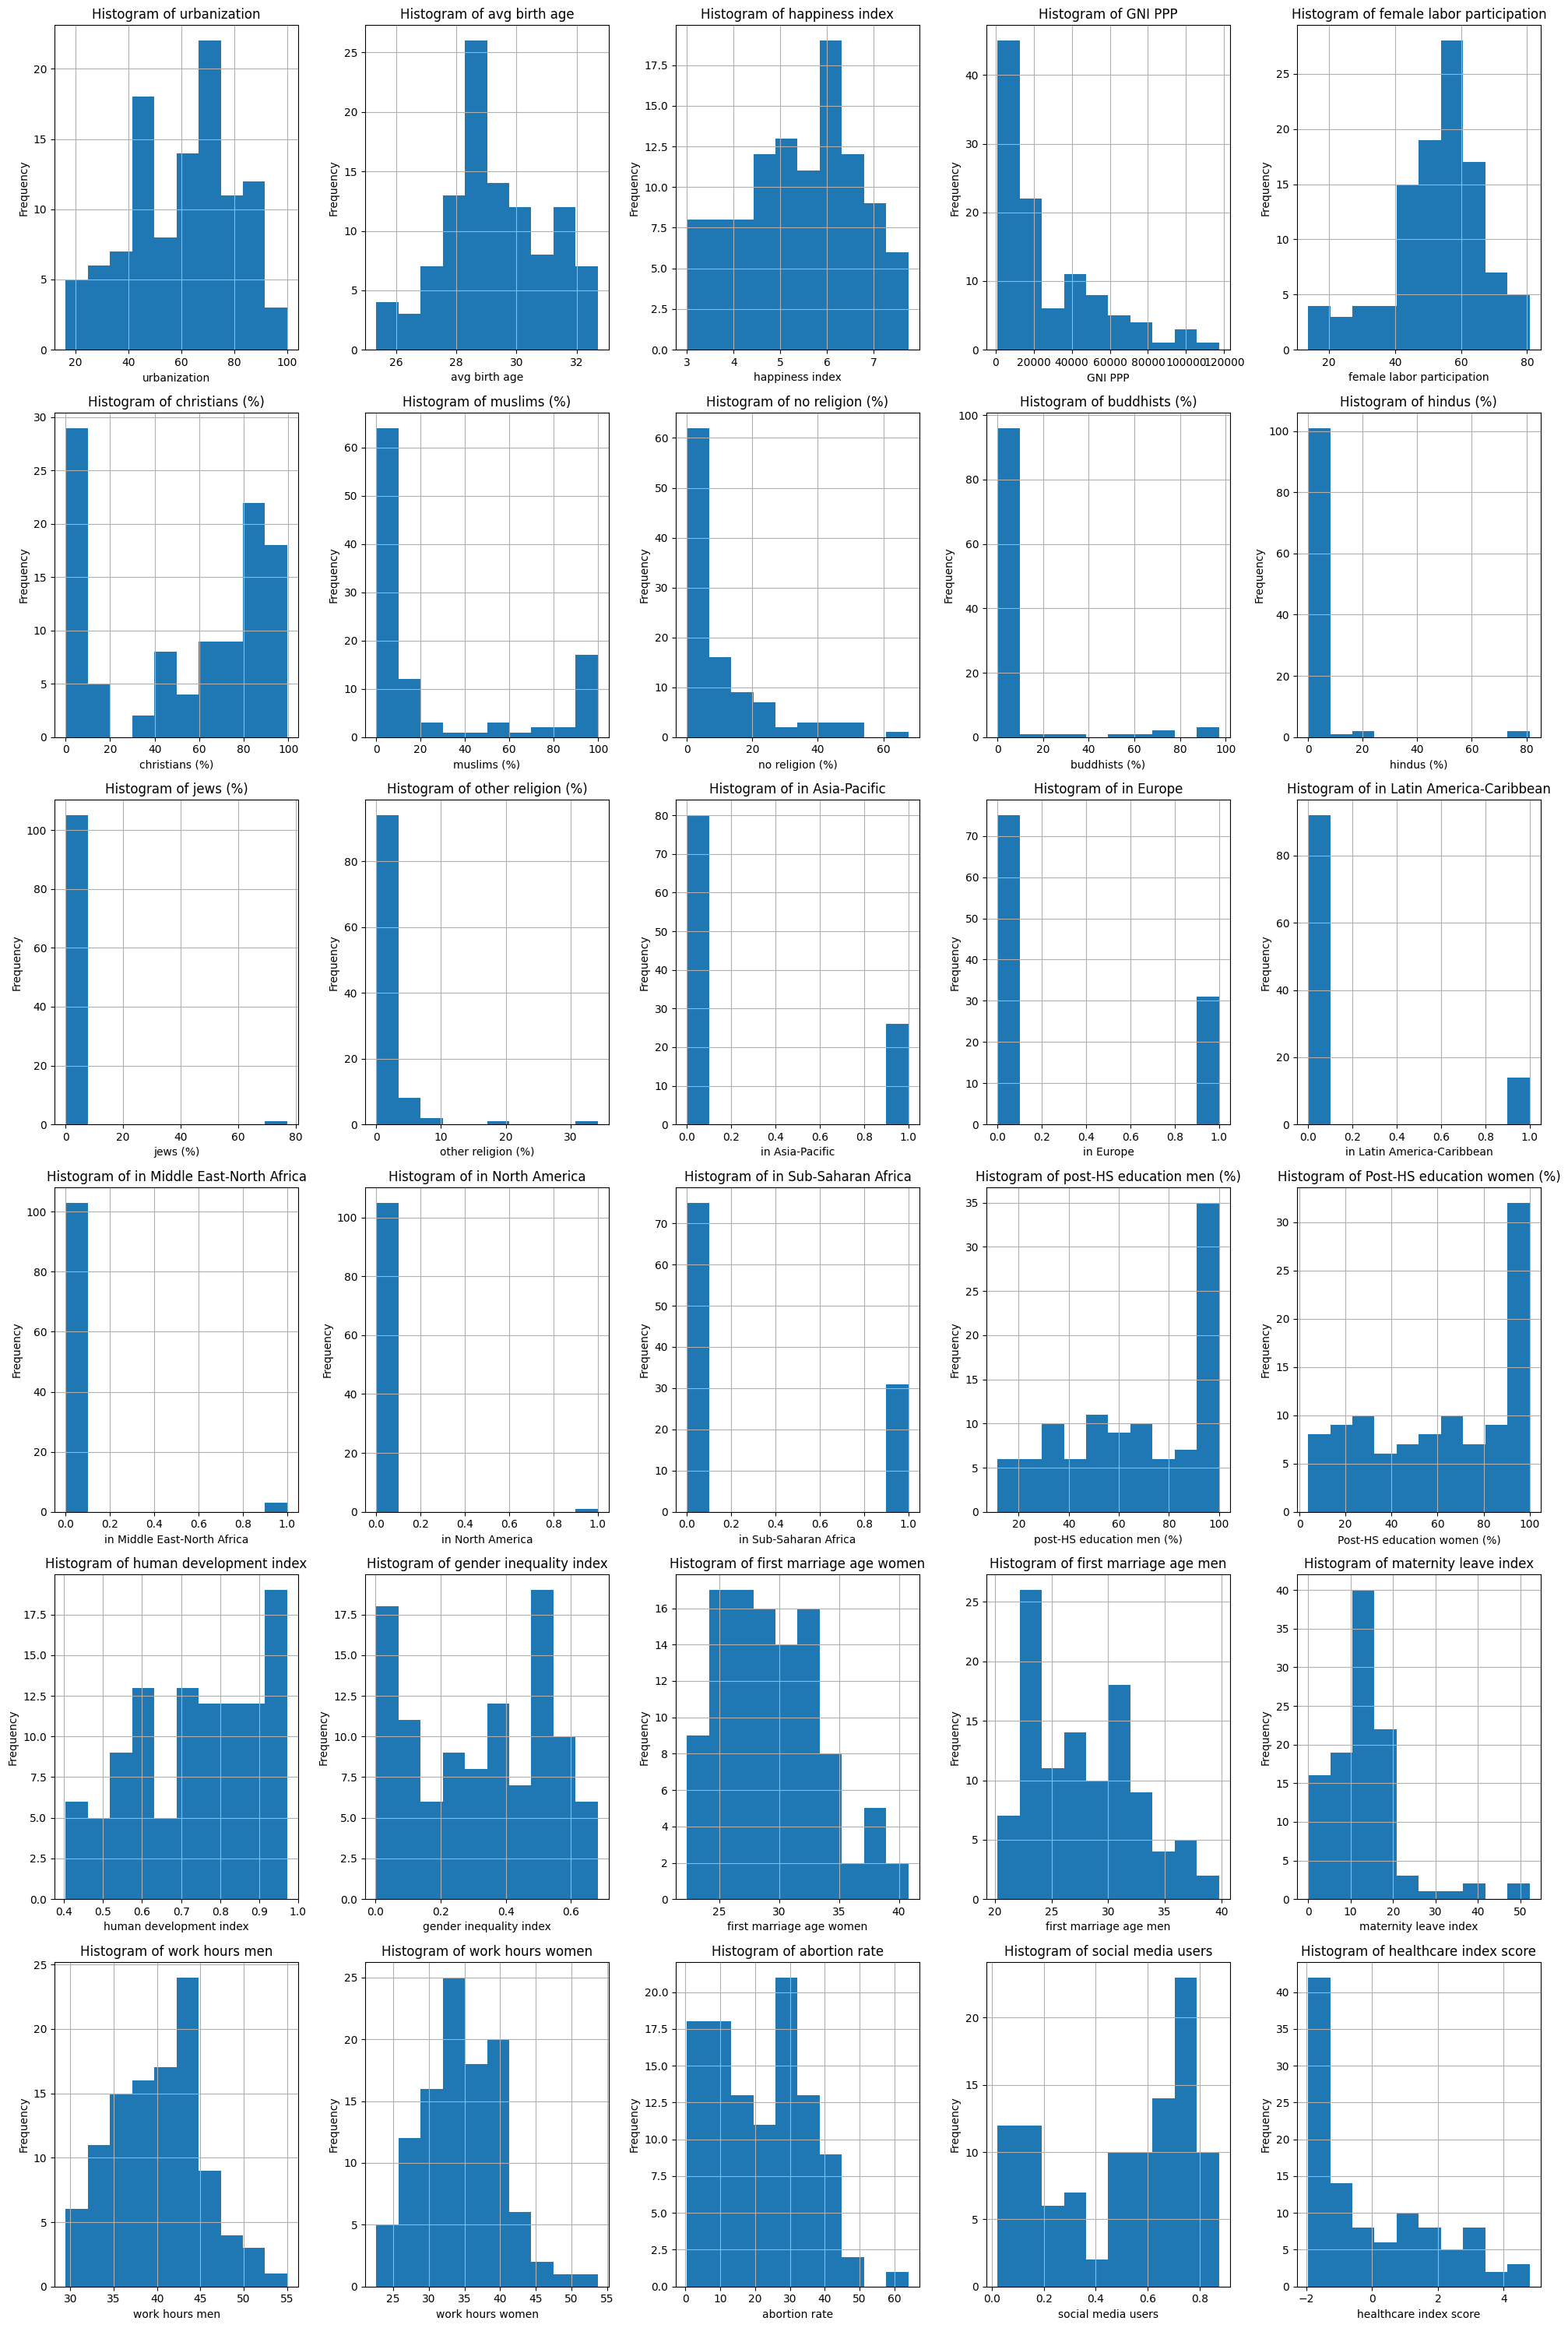

scaled features


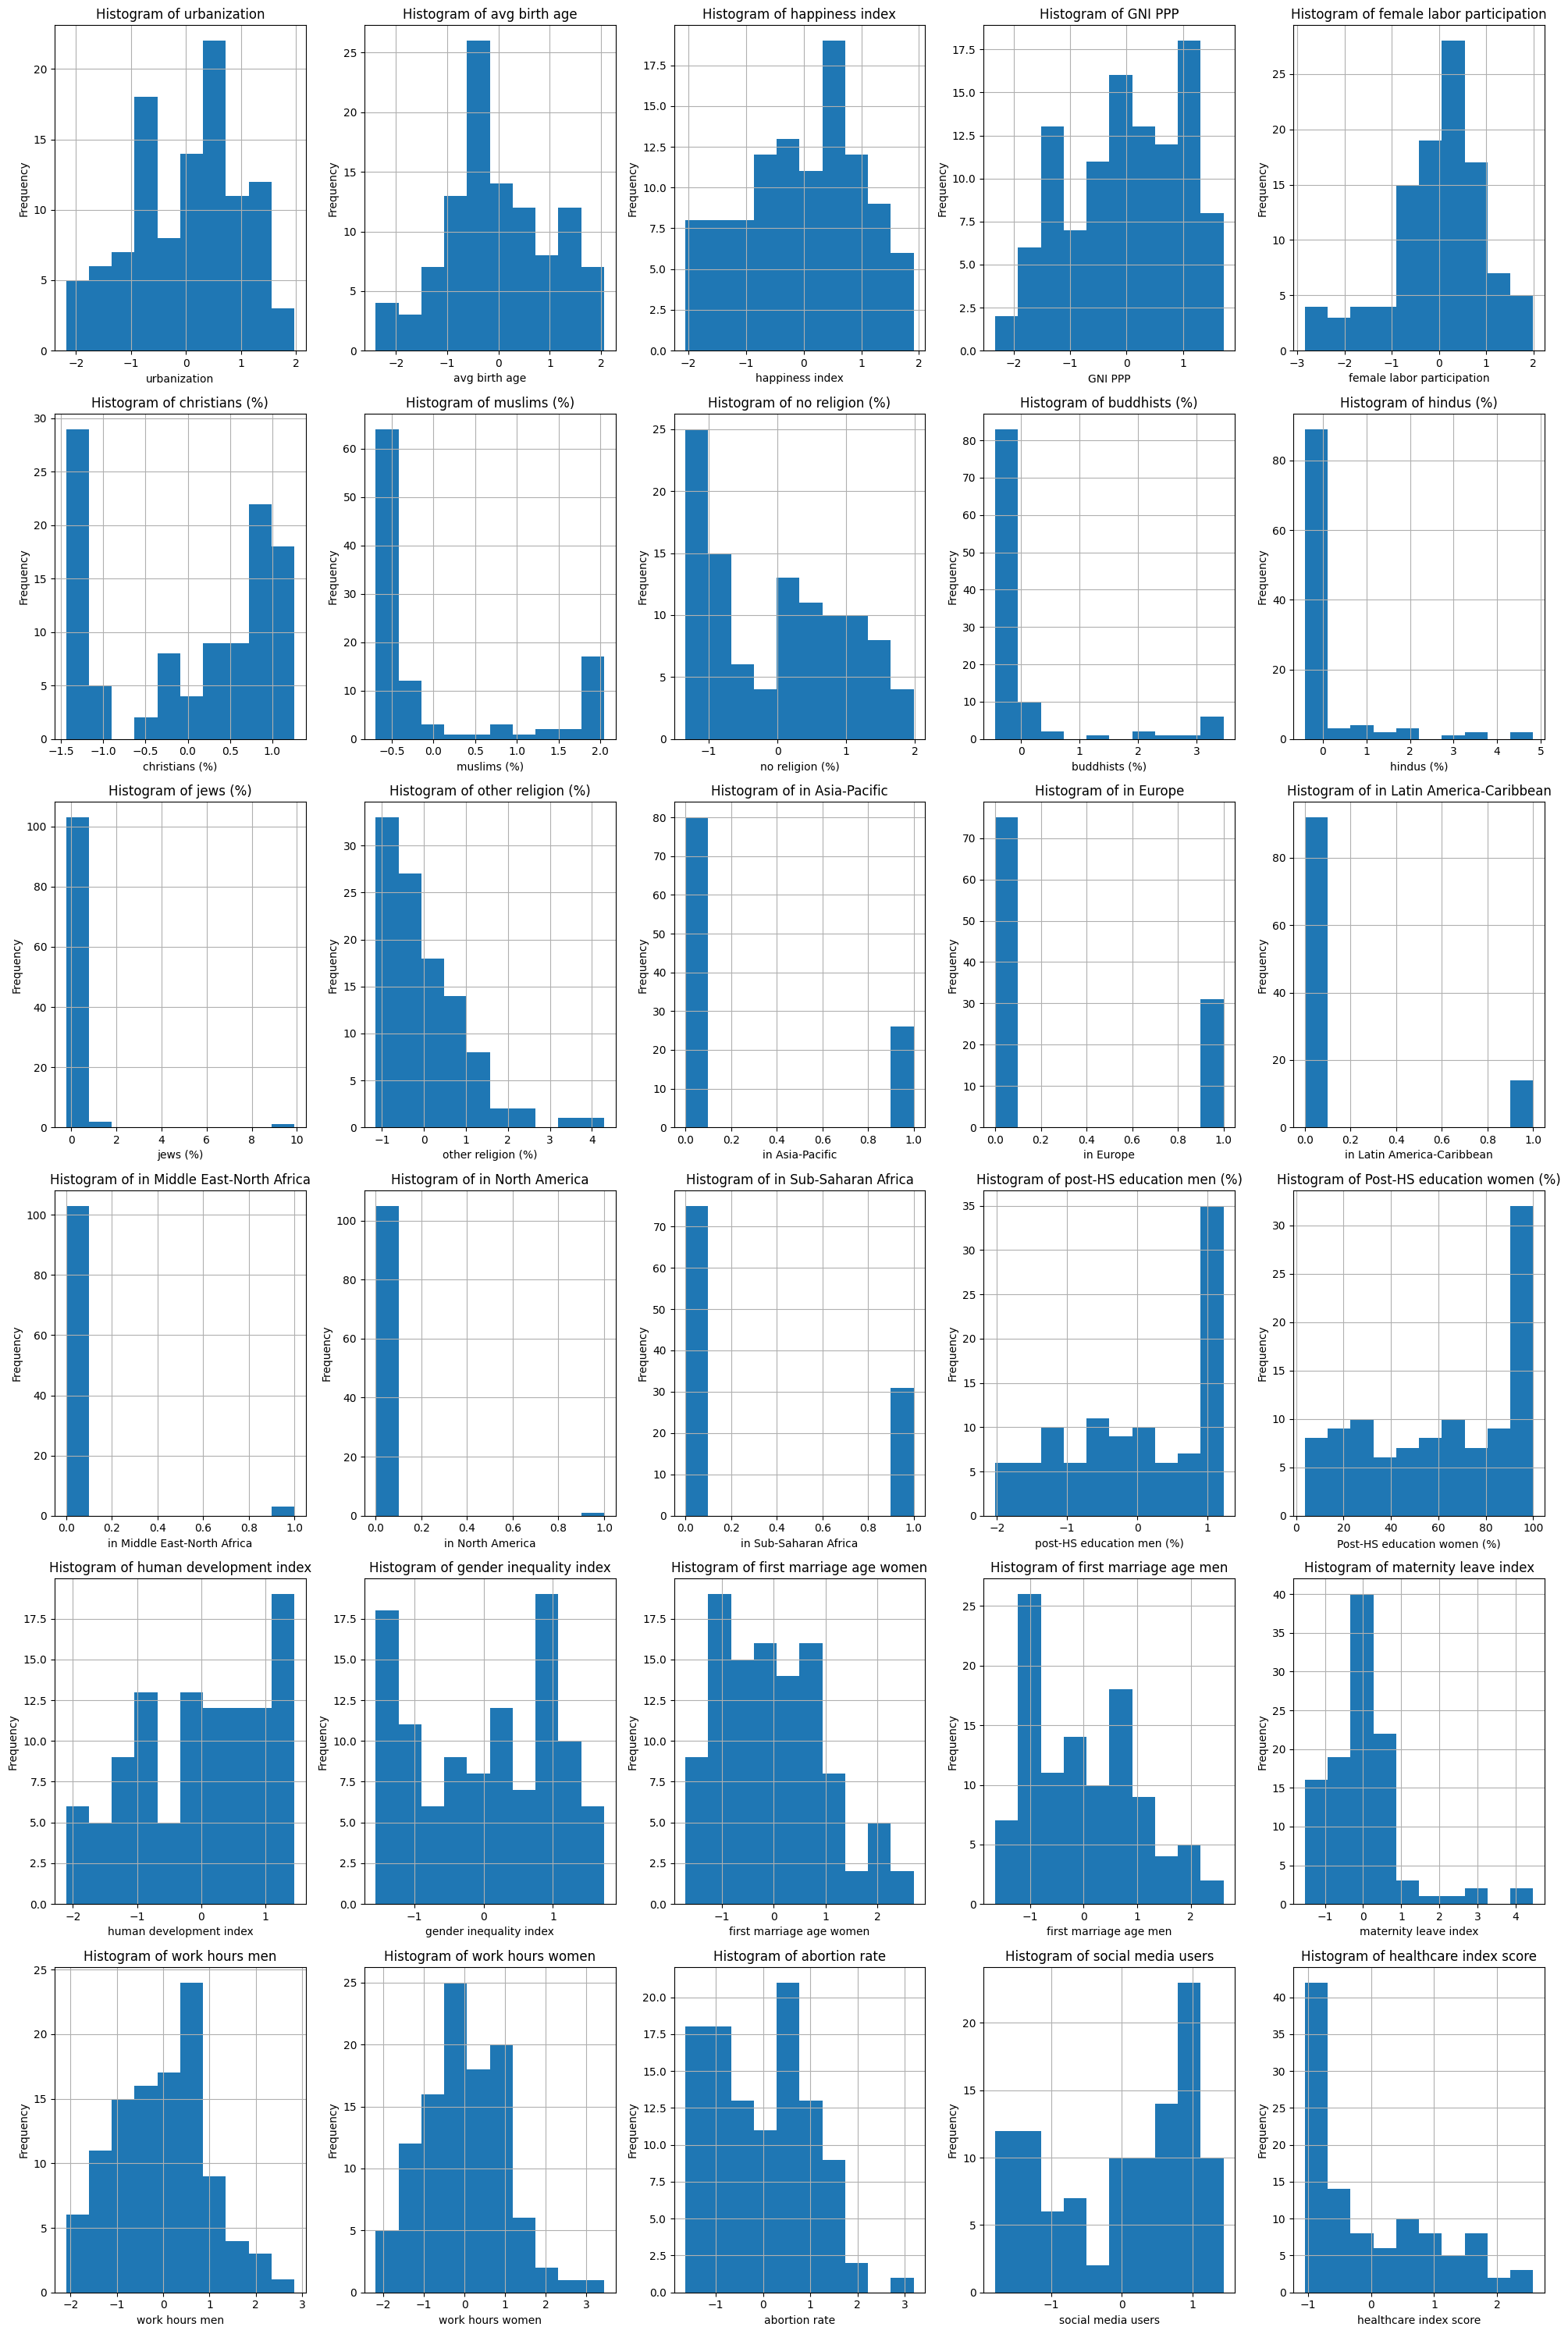

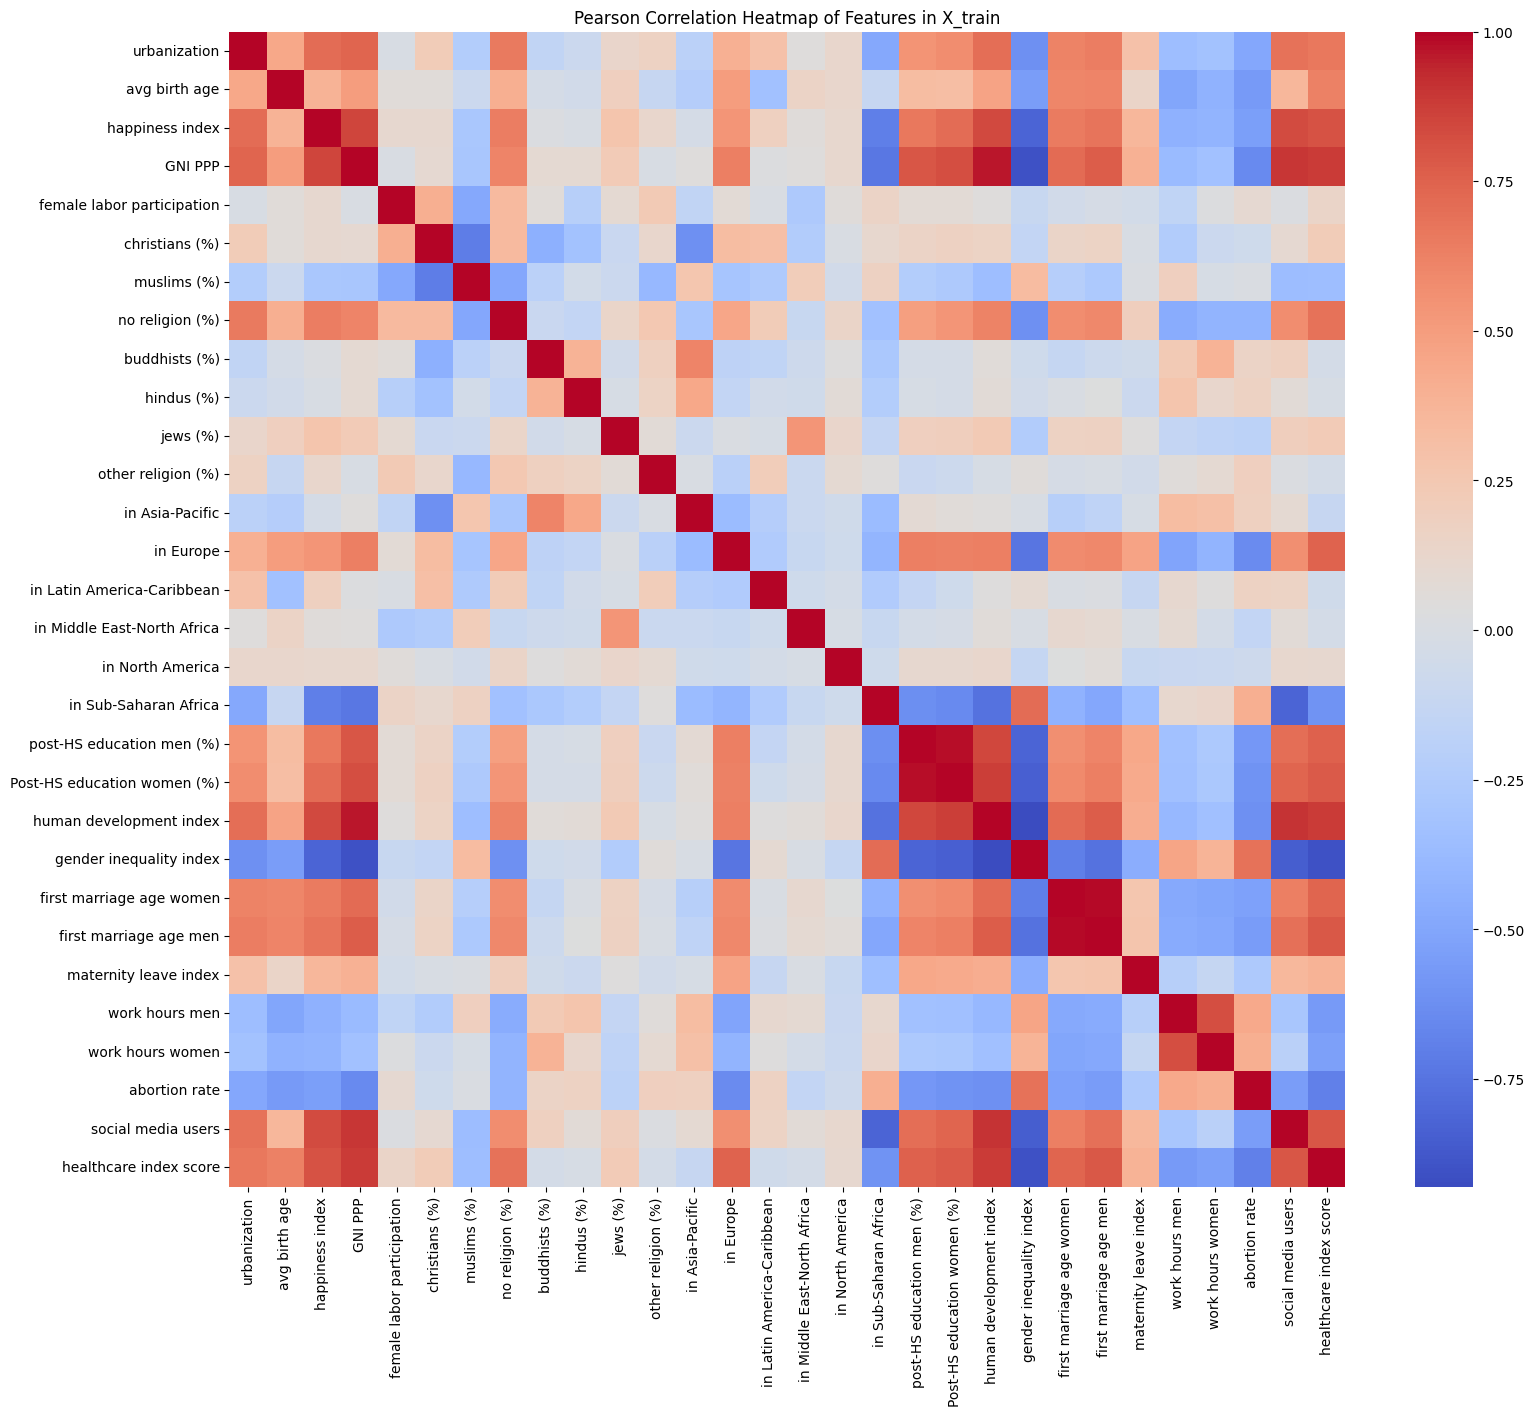


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  first marriage age women and first marriage age men: 0.9895
  post-HS education men (%) and Post-HS education women (%): 0.9805
  GNI PPP and human development index: 0.9682
  human development index and gender inequality index: -0.9295
  gender inequality index and healthcare index score: -0.9056


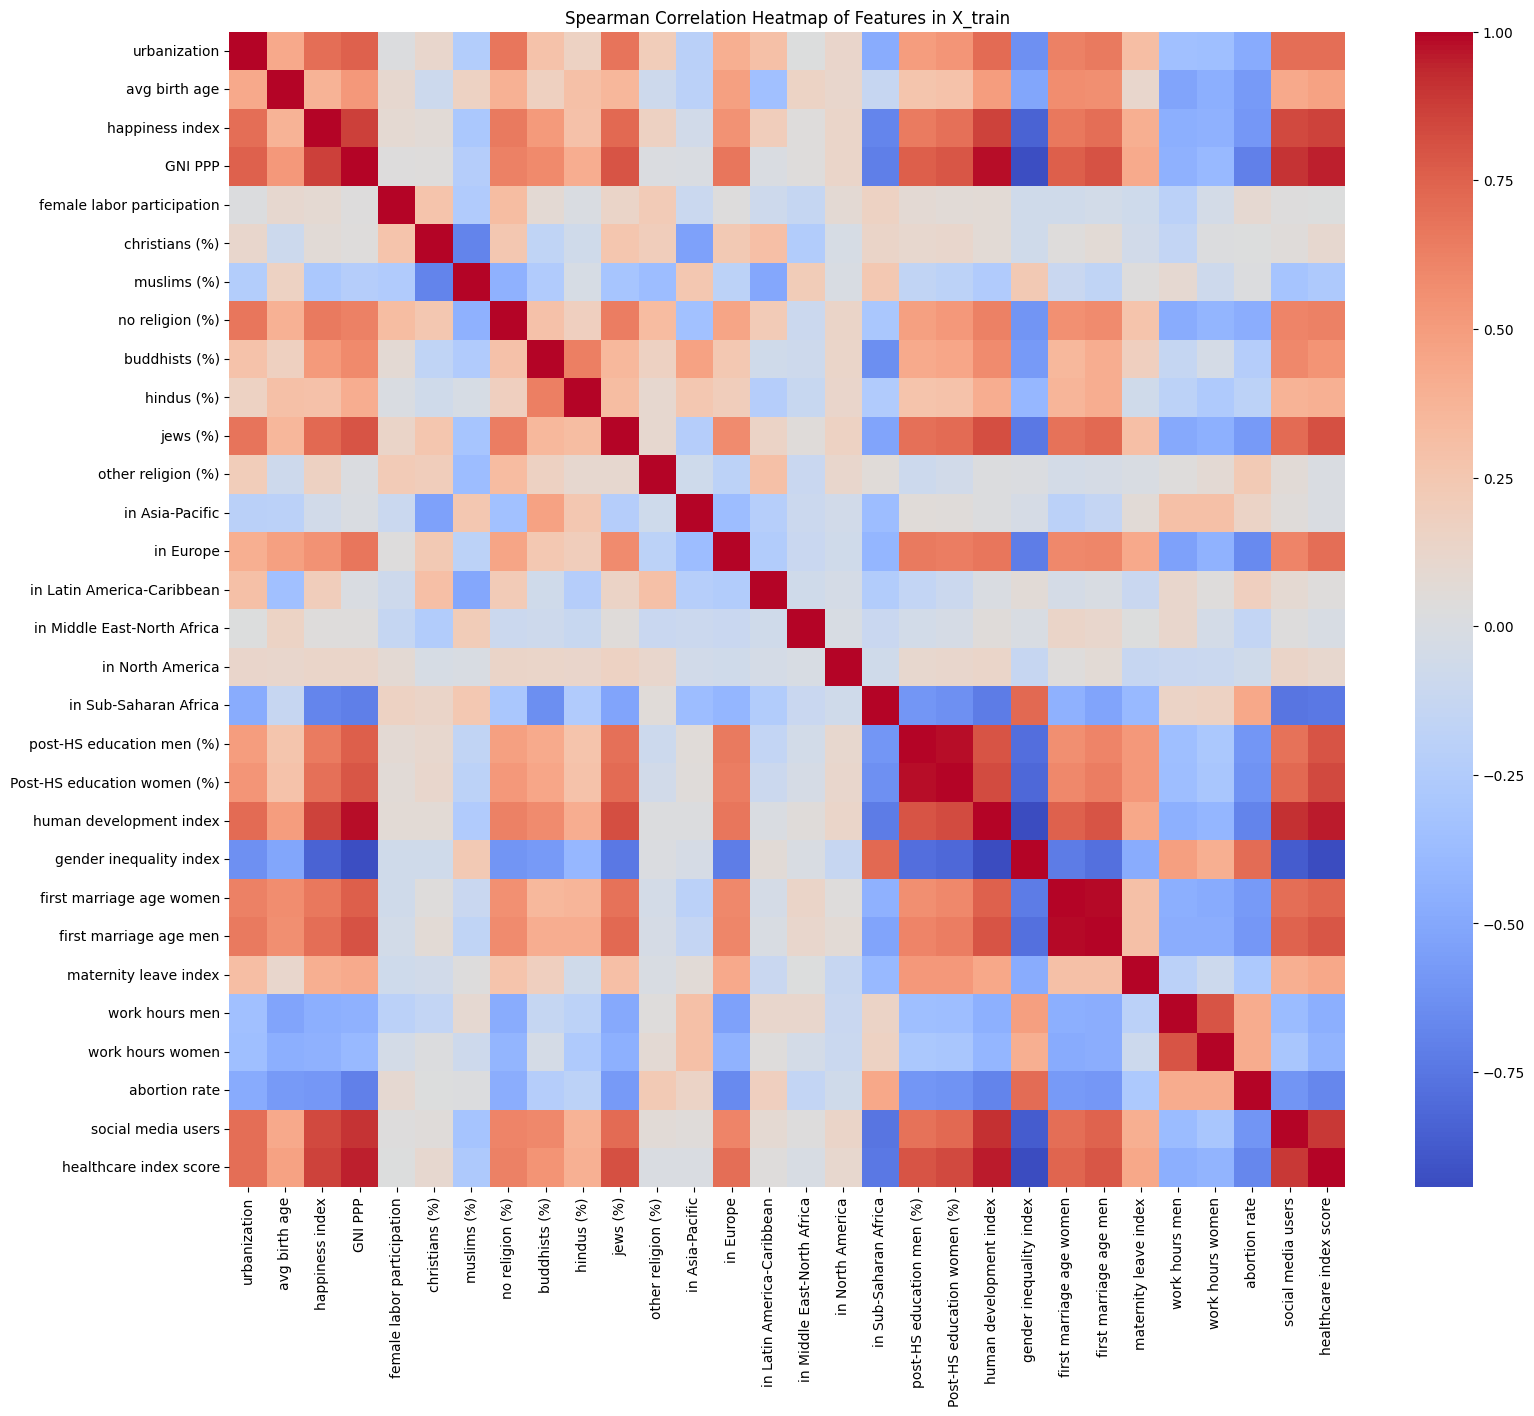


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  first marriage age women and first marriage age men: 0.9871
  post-HS education men (%) and Post-HS education women (%): 0.9820
  GNI PPP and human development index: 0.9781
  human development index and healthcare index score: 0.9605
  GNI PPP and healthcare index score: 0.9491


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


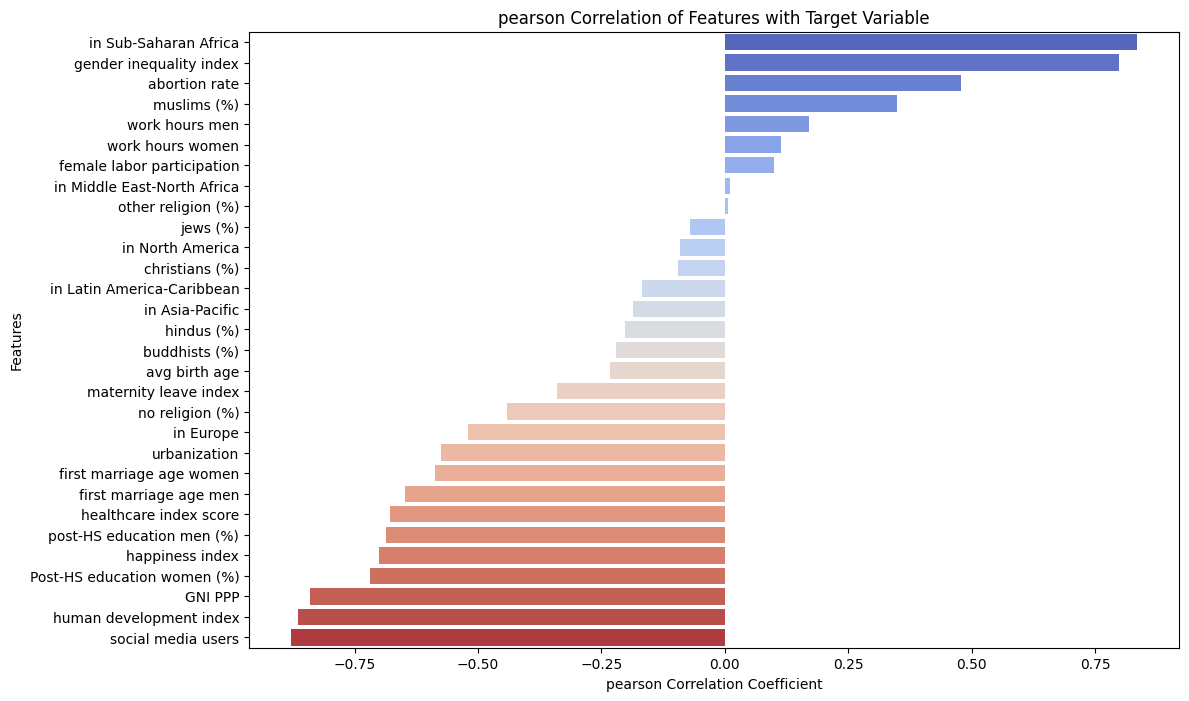


pearson Correlation with Target:
in Sub-Saharan Africa          0.834381
gender inequality index        0.797438
abortion rate                  0.478885
muslims (%)                    0.349747
work hours men                 0.170845
work hours women               0.114112
female labor participation     0.099885
in Middle East-North Africa    0.011170
other religion (%)             0.005654
jews (%)                      -0.071159
in North America              -0.090590
christians (%)                -0.094503
in Latin America-Caribbean    -0.167194
in Asia-Pacific               -0.185259
hindus (%)                    -0.202353
buddhists (%)                 -0.220292
avg birth age                 -0.232213
maternity leave index         -0.339560
no religion (%)               -0.440683
in Europe                     -0.519533
urbanization                  -0.575595
first marriage age women      -0.586678
first marriage age men        -0.647425
healthcare index score        -0.677832
post-H

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


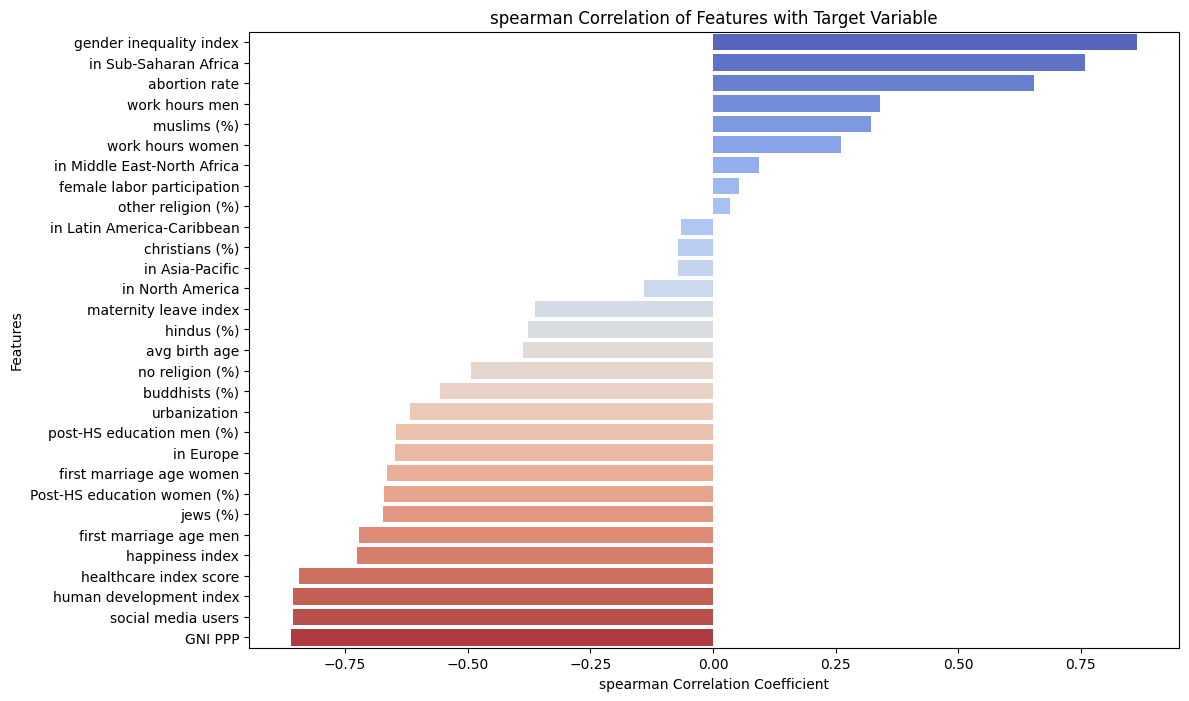


spearman Correlation with Target:
gender inequality index        0.863911
in Sub-Saharan Africa          0.758841
abortion rate                  0.654204
work hours men                 0.341201
muslims (%)                    0.322241
work hours women               0.260881
in Middle East-North Africa    0.093897
female labor participation     0.053731
other religion (%)             0.035053
in Latin America-Caribbean    -0.066026
christians (%)                -0.070489
in Asia-Pacific               -0.070590
in North America              -0.140345
maternity leave index         -0.362375
hindus (%)                    -0.376686
avg birth age                 -0.387128
no religion (%)               -0.494177
buddhists (%)                 -0.556041
urbanization                  -0.616775
post-HS education men (%)     -0.646761
in Europe                     -0.647336
first marriage age women      -0.663912
Post-HS education women (%)   -0.669942
jews (%)                      -0.672670
first

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


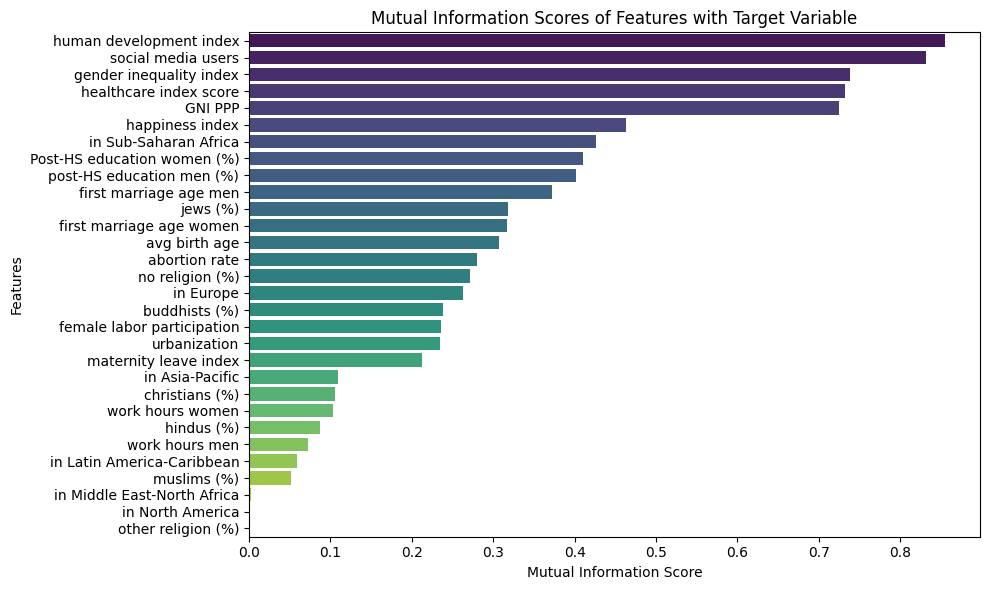


lasso regressor:
Best params: {'lasso__alpha': 0.02}
CV MSE: 0.3480 (±0.7677)

coefficients:
human development index: -0.5961
in Sub-Saharan Africa: 0.3977
social media users: -0.3718
gender inequality index: 0.1824
avg birth age: 0.1620
female labor participation: 0.1515
muslims (%): 0.1148
jews (%): 0.1132
first marriage age men: -0.1119
work hours women: -0.1068
hindus (%): -0.0547
buddhists (%): -0.0323
no religion (%): 0.0319
healthcare index score: 0.0198
other religion (%): 0.0051
maternity leave index: 0.0037
Post-HS education women (%): 0.0011
happiness index: 0.0002
urbanization: 0.0000
in Asia-Pacific: -0.0000
GNI PPP: -0.0000
christians (%): -0.0000
in Europe: -0.0000
in Latin America-Caribbean: -0.0000
in Middle East-North Africa: 0.0000
in North America: -0.0000
post-HS education men (%): 0.0000
first marriage age women: -0.0000
work hours men: -0.0000
abortion rate: 0.0000

elastic net regressor:
Best params: {'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.1}
CV MSE: 0.3

In [54]:
## 2023 data##
X_train, X_test, y_train, y_test = process_2023_data(init_process())

#feature distrebutions
unscaled_X_train,unscaled_X_test = create_health_index_score(X_train.copy(),X_test.copy())
print('unscaled features')
plot_features(unscaled_X_train)

scaler = Scaling2023()
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

print('scaled features')
plot_features(scaled_train)

#feature pairs correlations
feature_correlations(scaled_train, 'pearson')
feature_correlations(scaled_train, 'spearman')
#feature-target correlations and mutual information
analyze_target_correlation(scaled_train, y_train, 'pearson')
analyze_target_correlation(scaled_train, y_train, 'spearman')
analyze_mutual_information(scaled_train, y_train)
#linear regressor models
print('\nlasso regressor:')
lasso_gs = gridsearch_loocv_lasso(X_train,y_train)
report_grid_search(lasso_gs,X_train,'lasso')
print('\nelastic net regressor:')
elastic_net_gs = gridsearch_elastic_net_loocv(X_train,y_train)
report_grid_search(elastic_net_gs,X_train,'elastic')
#random forest regressor model
print('\nrandom forest regressor:')
rf_gs = gridsearch_random_forest(X_train,y_train)
report_grid_search(rf_gs,X_train,'rf')
#xgboost regressor model
print('\nxgboost regressor:')
xgb_gs = gridsearch_xgboost(X_train,y_train)
report_grid_search(xgb_gs,X_train,'xgb')

In [16]:
print(X_train.select_dtypes(include='object').columns.tolist())
print('++++')
print(X_train[['in Asia-Pacific', 'in Europe', 'in Latin America-Caribbean',
         'in Middle East-North Africa', 'in North America', 'in Sub-Saharan Africa']].dtypes)


['urbanization', 'avg birth age', 'happiness', 'health expenditure', 'physicians per capita', 'GNI PPP', 'female labor participation', 'christians', 'muslims', 'no religion', 'buddhists', 'hindus', 'jews', 'other religion', 'in Asia-Pacific', 'in Europe', 'in Latin America-Caribbean', 'in Middle East-North Africa', 'in North America', 'in Sub-Saharan Africa', 'education man', 'education women', 'hdi', 'gii', 'avg marriage age women', 'avg marriage age men', 'maternity leave index', 'work hours men', 'work hours women', 'abortions', 'social media users']
++++
in Asia-Pacific                object
in Europe                      object
in Latin America-Caribbean     object
in Middle East-North Africa    object
in North America               object
in Sub-Saharan Africa          object
dtype: object


In [ ]:
rf_gs = gridsearch_random_forest(X_train,y_train)
report_grid_search(rf_gs,X_train,'rf')
#xgboost regressor model
print('\nxgboost regressor:')
xgb_gs = gridsearch_xgboost(X_train,y_train)
report_grid_search(xgb_gs,X_train,'xgb')

Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
CV MSE: 0.3397 (±0.1473)

feature importance:
social media users: 0.1793
gii: 0.1180
in Sub-Saharan Africa: 0.1169
healthcare index score: 0.1027
GNI PPP: 0.0988
hdi: 0.0974
education women: 0.0394
avg marriage age men: 0.0310
happiness: 0.0270
education man: 0.0259
buddhists: 0.0255
urbanization: 0.0177
avg marriage age women: 0.0164
jews: 0.0129
abortions: 0.0121
avg birth age: 0.0102
no religion: 0.0101
maternity leave index: 0.0084
muslims: 0.0084
work hours men: 0.0081
hindus: 0.0075
female labor participation: 0.0058
christians: 0.0052
work hours women: 0.0049
in Europe: 0.0038
other religion: 0.0033
in Asia-Pacific: 0.0025
in Latin America-Caribbean: 0.0004
in Middle East-North Africa: 0.0004
in North America: 0.0000

xgboost regressor:


ValueError: 
All the 9720 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9720 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 407, in pandas_feature_info
    new_feature_types.append(_pandas_dtype_mapper[dtype.name])
                             ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'object'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1222, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 628, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py", line 1137, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 1614, in __init__
    self._init(
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 1678, in _init
    it.reraise()
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 572, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 553, in _handle_exception
    return fn()
           ^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 640, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
                                              ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 1654, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/core.py", line 620, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 1707, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
                                       ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 640, in _transform_pandas_df
    feature_names, feature_types = pandas_feature_info(
                                   ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 409, in pandas_feature_info
    _invalid_dataframe_dtype(data)
  File "/usr/local/lib/python3.12/dist-packages/xgboost/data.py", line 372, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:in Asia-Pacific: object, in Europe: object, in Latin America-Caribbean: object, in Middle East-North Africa: object, in North America: object, in Sub-Saharan Africa: object


In [19]:
xgb_gs = gridsearch_xgboost(X_train,y_train)
report_grid_search(xgb_gs,X_train,'xgb')

Best params: {'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 600, 'xgb__subsample': 0.5}
CV MSE: 0.3252 (±0.0835)


ValueError: invalid literal for int() with base 10: 'rbanization'

In [21]:
report_grid_search(xgb_gs,X_train,'xgb')

Best params: {'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 600, 'xgb__subsample': 0.5}
CV MSE: 0.3252 (±0.0835)

mean gain by feature:
in Sub-Saharan Africa: 0.3456
social media users: 0.2186
hdi: 0.1050
gii: 0.0666
healthcare index score: 0.0519
GNI PPP: 0.0248
avg marriage age men: 0.0218
in Asia-Pacific: 0.0174
in Middle East-North Africa: 0.0147
education women: 0.0107
avg marriage age women: 0.0105
education man: 0.0101
in Latin America-Caribbean: 0.0099
muslims: 0.0090
jews: 0.0089
abortions: 0.0088
hindus: 0.0083
work hours women: 0.0073
buddhists: 0.0070
work hours men: 0.0060
avg birth age: 0.0054
no religion: 0.0053
maternity leave index: 0.0052
female labor participation: 0.0051
happiness: 0.0041
christians: 0.0036
in Europe: 0.0032
other religion: 0.0028
urbanization: 0.0025
in North America: 0.0000


In [ ]:
report_rf_grid(rf_gs,X_train)

Best params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
CV MSE: 0.3397 (±0.1473)

feature importance:
social media users: 0.1793
gii: 0.1180
in Sub-Saharan Africa: 0.1169
healthcare index score: 0.1027
GNI PPP: 0.0988
hdi: 0.0974
education women: 0.0394
avg marriage age men: 0.0310
happiness: 0.0270
education man: 0.0259
buddhists: 0.0255
urbanization: 0.0177
avg marriage age women: 0.0164
jews: 0.0129
abortions: 0.0121
avg birth age: 0.0102
no religion: 0.0101
maternity leave index: 0.0084
muslims: 0.0084
work hours men: 0.0081
hindus: 0.0075
female labor participation: 0.0058
christians: 0.0052
work hours women: 0.0049
in Europe: 0.0038
other religion: 0.0033
in Asia-Pacific: 0.0025
in Latin America-Caribbean: 0.0004
in Middle East-North Africa: 0.0004
in North America: 0.0000


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming grid_search_rf, X_train, y_train, X_test, and y_test are already defined

# Get the best trained Random Forest model
best_rf_model = rf_gs.best_estimator_

# --- Evaluate on Training Set ---
y_train_pred_rf = best_rf_model.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

print(f"Training Set Performance:")
print(f"  Mean Squared Error: {mse_train_rf:.4f}")
print(f"  R-squared: {r2_train_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Evaluate on Test Set ---
y_test_pred_rf = best_rf_model.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"Test Set Performance:")
print(f"  Mean Squared Error: {mse_test_rf:.4f}")
print(f"  R-squared: {r2_test_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Validation Set Performance (from Grid Search) ---
# The best_score_ from GridSearchCV is the mean cross-validation score (negative MSE)
validation_neg_mse = rf_gs.best_score_
validation_mse = -validation_neg_mse # Convert negative MSE to positive MSE

print(f"Validation Set Performance (from Grid Search):")
print(f"  Mean Cross-Validation MSE: {validation_mse:.4f}")
# Note: R-squared is not directly available from best_score_ if MSE was the scoring metric
# You could calculate R-squared on the validation folds separately if needed.

Training Set Performance:
  Mean Squared Error: 0.0740
  R-squared: 0.9602


Test Set Performance:
  Mean Squared Error: 0.1473
  R-squared: 0.8882


Validation Set Performance (from Grid Search):
  Mean Cross-Validation MSE: 0.3397
